In [ ]:
!pip install keras

SECTION 1: INITIALIZING ENVIRONMENT & CONSTANTS
Environment ready.

Starting CME Detection Pipeline...

SECTION 2: DATA LOADING & PREPARATION
Cleaning and preparing data...
   - Dropping 6 columns with >70.0% NaN values.
Data prepared successfully.
Engineering physics-based features...
Feature engineering complete.
Cleaning and preparing data...
   - Dropping 20 columns with >70.0% NaN values.
Data prepared successfully.
Engineering physics-based features...
Feature engineering complete.

SECTION 3: MODEL TRAINING
Detecting RH-confirmed shocks for training labels...
   - Found 1066 statistical candidates.
Found 115 RH-confirmed shocks to use as training labels.
Scaling features for the model...
Creating sequences of length 32...
Building CNN-LSTM-Attention model architecture...
Model built successfully.
 Training model on generated labels...
Epoch 1/4
3348/3348 ━━━━━━━━━━━━━━━━━━━━ 145s 42ms/step - accuracy: 0.9915 - loss: 0.0118 - val_accuracy: 0.9979 - val_loss: 9.4645e-04
Epoch 2/4


MC Dropout Runs:   0%|          | 0/50 [00:00<?, ?it/s]

PVSS computed successfully.

 Top 5 Highest PVSS Score Candidates 

--- Candidate #1 ---
  - Time: 2024-10-10 13:12:07.940000+00:00
  - PVSS Score: 0.0038
  - Proton Speed: 409.2 km/s
  - B_total: 4.5 nT
  - Density: 1.94 p/cm³
  - Entropy Gradient: 0.07

--- Candidate #2 ---
  - Time: 2024-10-10 14:03:52.971000+00:00
  - PVSS Score: 0.0036
  - Proton Speed: 436.9 km/s
  - B_total: 4.7 nT
  - Density: 2.04 p/cm³
  - Entropy Gradient: 0.09

--- Candidate #3 ---
  - Time: 2024-10-10 13:12:02.940000+00:00
  - PVSS Score: 0.0034
  - Proton Speed: 409.2 km/s
  - B_total: 5.3 nT
  - Density: 1.94 p/cm³
  - Entropy Gradient: 0.19

--- Candidate #4 ---
  - Time: 2024-10-10 14:33:42.988000+00:00
  - PVSS Score: 0.0034
  - Proton Speed: 467.5 km/s
  - B_total: 5.4 nT
  - Density: 3.36 p/cm³
  - Entropy Gradient: 0.62

--- Candidate #5 ---
  - Time: 2024-10-10 14:33:12.988000+00:00
  - PVSS Score: 0.0032
  - Proton Speed: 482.6 km/s
  - B_total: 9.1 nT
  - Density: 2.98 p/cm³
  - Entropy Gradient

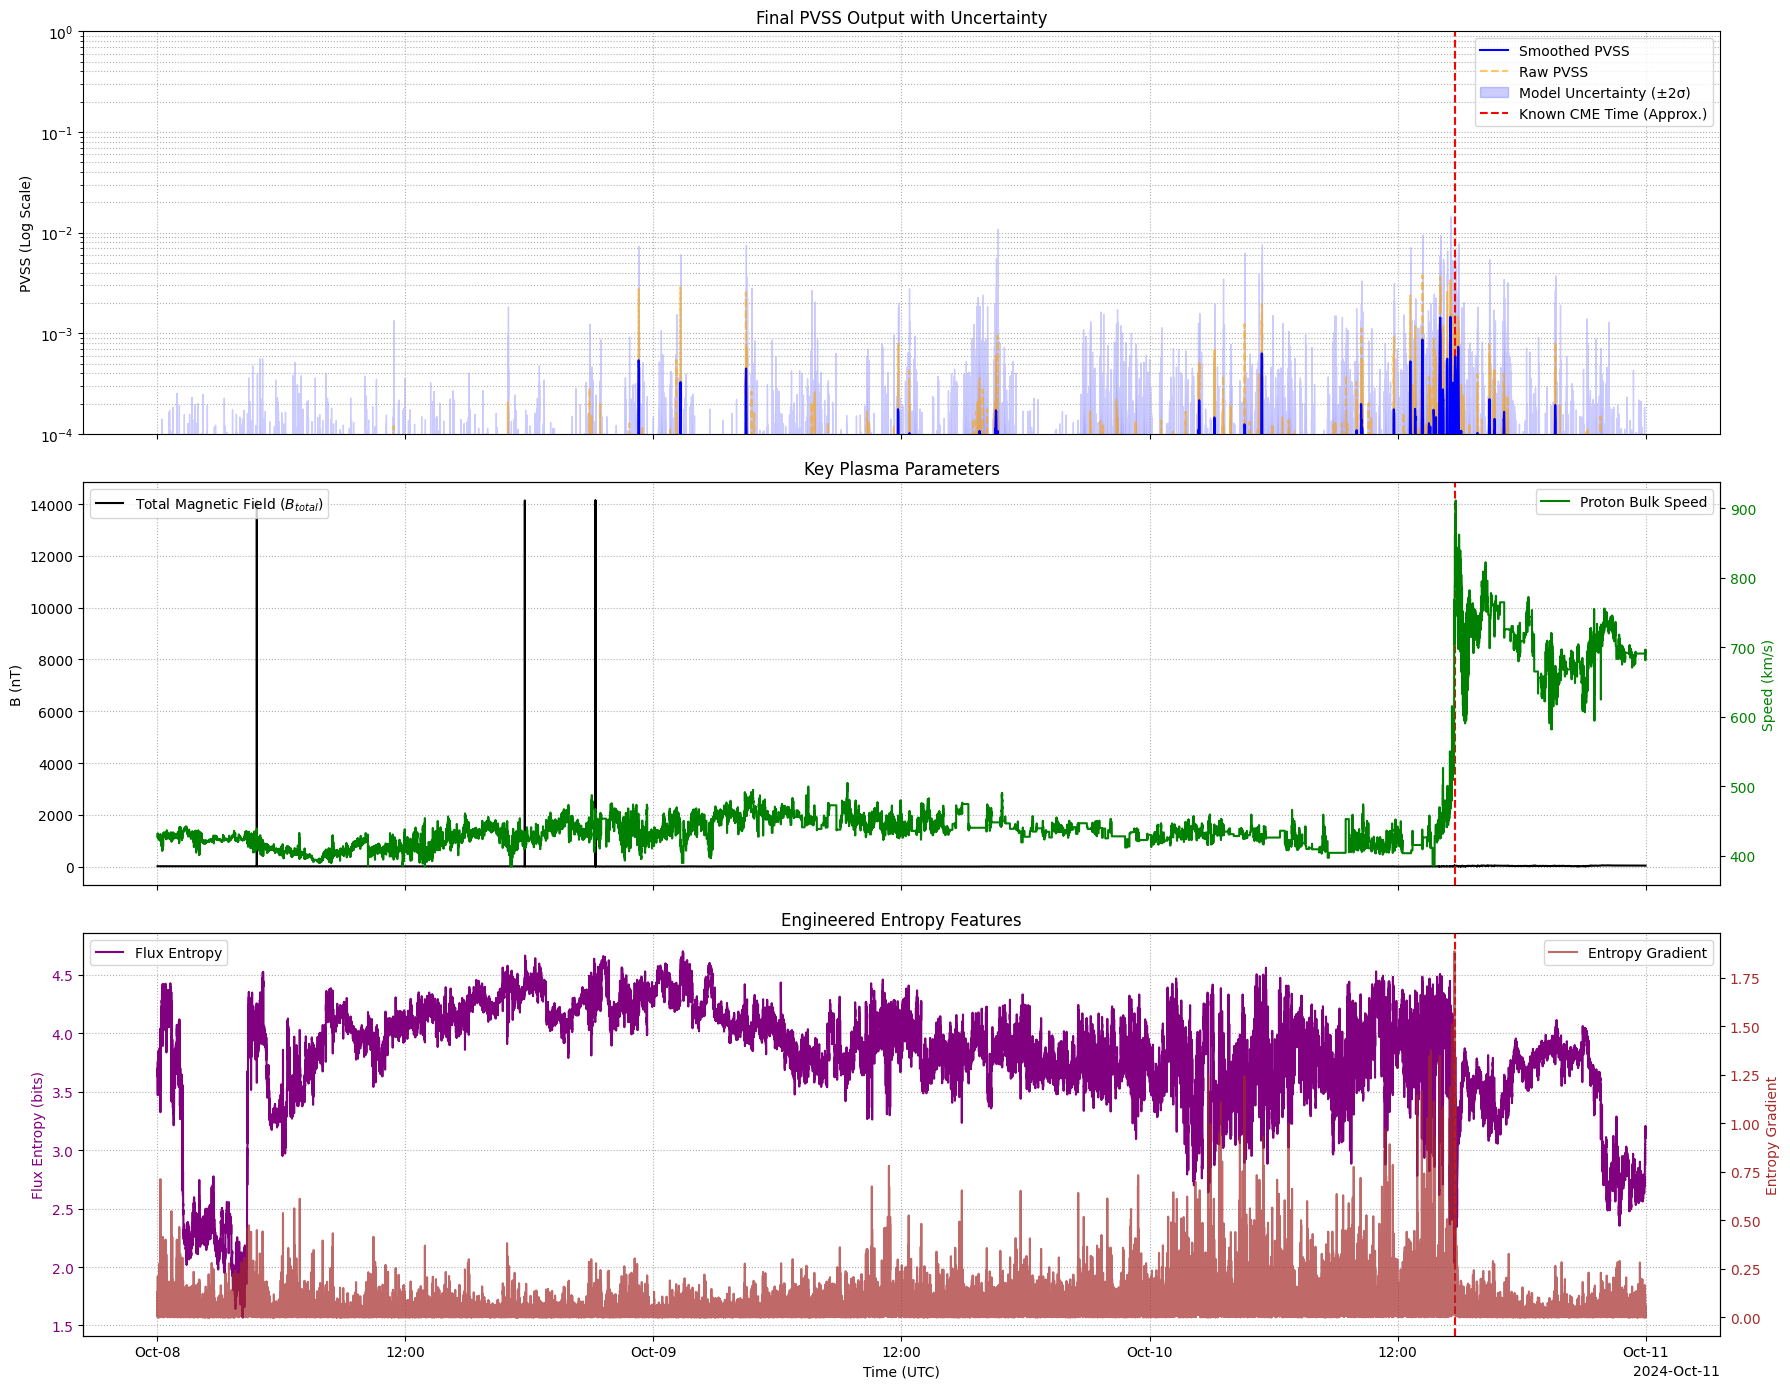


 Pipeline execution complete.


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import (
    Input, Conv1D, MaxPooling1D, LSTM, Attention,
    GlobalMaxPooling1D, Dropout, Dense
)
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2
from scipy.spatial.distance import mahalanobis
import matplotlib.pyplot as plt
from matplotlib.dates import ConciseDateFormatter
from tqdm.notebook import tqdm
import warnings

# --- Global Settings ---
warnings.filterwarnings('ignore')

# --- Physical Constants ---
print("SECTION 1: INITIALIZING ENVIRONMENT & CONSTANTS")
kB = 1.380649e-23
mu0 = 4 * np.pi * 1e-7
mp = 1.6726219e-27
gamma = 5/3
NAN_DROP_THRESHOLD = 0.7
print("Environment ready.")

# --- Data Loader and Feature Engineering ---
def load_and_prepare_data(df, is_test_data=False):
    """Cleans, harmonizes, and prepares a dataframe."""
    print("Cleaning and preparing data...")
    df.replace([-1e31, -9999, -9.999e+03, -1.000e+31], np.nan, inplace=True)
    if 'time' in df.columns:
        df['time'] = pd.to_datetime(df['time'], errors='coerce')
        df.dropna(subset=['time'], inplace=True)
        df.set_index('time', inplace=True)
    df.sort_index(inplace=True)
    if df.index.has_duplicates:
        print(f"   - Warning: Found and removed {df.index.duplicated().sum()} duplicate timestamps.")
        df = df[~df.index.duplicated(keep='first')]
    nan_ratios = df.isnull().mean()
    high_nan_cols = nan_ratios[nan_ratios > NAN_DROP_THRESHOLD].index
    if not high_nan_cols.empty:
        print(f"   - Dropping {len(high_nan_cols)} columns with >{NAN_DROP_THRESHOLD*100}% NaN values.")
        df.drop(columns=high_nan_cols, inplace=True)
    rename_map = {'Bt': 'B_total', 'proton_density_blk': 'proton_density',
                  'proton_bulk_speed_blk': 'proton_bulk_speed', 'proton_thermal_blk': 'proton_thermal'}
    df.rename(columns=rename_map, inplace=True)
    df = df.loc[:, ~df.columns.duplicated(keep='first')]
    flux_cols = sorted([col for col in df.columns if 'integrated_flux' in col])
    flux_rename_map = {old_name: f'flux_{i}' for i, old_name in enumerate(flux_cols[:50])}
    df.rename(columns=flux_rename_map, inplace=True)
    core = ['proton_density', 'proton_bulk_speed', 'proton_thermal', 'Bx_gsm', 'By_gsm', 'Bz_gsm', 'B_total']
    flux_std = [f'flux_{i}' for i in range(50)]
    df = df[[col for col in (core + flux_std) if col in df.columns]]
    df.ffill(inplace=True); df.bfill(inplace=True)
    print("Data prepared successfully.")
    return df

def engineer_features(df):
    """Calculates all physics-informed features."""
    print("Engineering physics-based features...")
    df = df.copy()
    B_si = df['B_total'] * 1e-9; n_si = df['proton_density'] * 1e6
    T_si = df['proton_thermal']; V_si = df['proton_bulk_speed'] * 1e3
    p_thermal = n_si * kB * T_si; p_magnetic = B_si**2 / (2 * mu0)
    df['plasma_beta'] = p_thermal / (p_magnetic + 1e-20)
    mass_density = n_si * mp
    df['alfven_speed'] = (B_si / np.sqrt(mu0 * mass_density + 1e-20)) / 1e3
    df['sound_speed'] = np.sqrt((gamma * kB * T_si) / mp) / 1e3
    df['sonic_mach_number'] = (V_si / 1e3) / (df['sound_speed'] + 1e-9)
    df['alfven_mach_number'] = (V_si / 1e3) / (df['alfven_speed'] + 1e-9)
    flux_cols = [f'flux_{i}' for i in range(50) if f'flux_{i}' in df.columns]
    if flux_cols:
        flux_data = df[flux_cols].values
        total_flux = flux_data.sum(axis=1, keepdims=True)
        p_i = (flux_data + 1e-20) / (total_flux + 1e-9)
        df['flux_entropy'] = -(p_i * np.log2(p_i)).sum(axis=1)
        df['entropy_gradient'] = df['flux_entropy'].diff().abs()
    for col in ['Bx_gsm', 'By_gsm', 'Bz_gsm', 'B_total']:
        if col in df.columns:
            df[f'd{col}_dt'] = df[col].diff()
    df.ffill(inplace=True); df.bfill(inplace=True)
    print("Feature engineering complete.")
    return df

# --- Shock Detection and Scoring ---
def find_rh_confirmed_shocks(df):
    """Finds high-confidence shock events for labeling."""
    print("Detecting RH-confirmed shocks for training labels...")
    X = df[['proton_bulk_speed', 'proton_density', 'proton_thermal', 'B_total']].values
    mahal_dist = np.zeros(len(df)); win = 120
    for i in range(win, len(X)):
        window = X[i-win:i]; mean = np.mean(window, axis=0)
        try:
            inv_cov = np.linalg.inv(np.cov(window, rowvar=False))
            mahal_dist[i] = mahalanobis(X[i], mean, inv_cov)
        except: mahal_dist[i] = 0
    df['mahalanobis_dist'] = mahal_dist
    df['shock_candidate_flag'] = (mahal_dist > chi2.ppf(0.999, df=4)).astype(int)
    df['RH_confirmed_shock'] = 0; df['compression_ratio'] = np.nan
    for idx in df[df['shock_candidate_flag'] == 1].index:
        up_start = idx - pd.Timedelta(minutes=5); up_end = idx - pd.Timedelta(seconds=5)
        down_start = idx + pd.Timedelta(seconds=5); down_end = idx + pd.Timedelta(minutes=5)
        if up_start in df.index and down_end in df.index:
            rho_up = df.loc[up_start:up_end, 'proton_density'].mean()
            rho_down = df.loc[down_start:down_end, 'proton_density'].mean()
            if rho_up > 0 and (rho_down / rho_up) > 1.5:
                df.loc[idx, 'RH_confirmed_shock'] = 1
                df.loc[idx, 'compression_ratio'] = rho_down / rho_up
    print(f"   - Found {df['shock_candidate_flag'].sum()} statistical candidates.")
    print(f"Found {df['RH_confirmed_shock'].sum()} RH-confirmed shocks to use as training labels.")
    return df

# --- Model Definition ---
def build_model(seq_len, n_feat):
    """Builds the CNN-LSTM-Attention model."""
    print("Building CNN-LSTM-Attention model architecture...")
    i = Input(shape=(seq_len, n_feat))
    x = Conv1D(64, 3, activation='relu')(i)
    x = MaxPooling1D()(x)
    x = LSTM(64, return_sequences=True)(x)
    x = Attention(use_scale=True)([x, x])
    x = GlobalMaxPooling1D()(x)
    x = Dropout(0.5)(x)
    o = Dense(1, activation='sigmoid')(x)
    model = Model(i, o)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print("Model built successfully.")
    return model

# --- Execution ---
if __name__ == '__main__':
    print("\nStarting CME Detection Pipeline...\n")
    # --- Data Loading ---
    print("SECTION 2: DATA LOADING & PREPARATION")
    train_df_raw = pd.read_parquet("/content/aditya_l1_master_training_data_5sec.parquet")
    test_df_raw = pd.read_csv("/content/swis_mag_master_combined.csv", low_memory=False)

    # --- Feature Engineering ---
    train_features = engineer_features(load_and_prepare_data(train_df_raw))
    test_features = engineer_features(load_and_prepare_data(test_df_raw, is_test_data=True))

    # --- Label Generation and Training ---
    print("\nSECTION 3: MODEL TRAINING")
    train_labeled = find_rh_confirmed_shocks(train_features)
    target = np.convolve(train_labeled['RH_confirmed_shock'], np.ones(30)/30, 'same')

    feat_cols = [c for c in train_labeled.columns if c in [
        'proton_density','proton_bulk_speed','proton_thermal','B_total','Bx_gsm','By_gsm','Bz_gsm',
        'plasma_beta','alfven_speed','sound_speed','sonic_mach_number','alfven_mach_number',
        'flux_entropy','entropy_gradient','dBx_gsm_dt','dBy_gsm_dt','dBz_gsm_dt','dB_total_dt']]

    print("Scaling features for the model...")
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train_labeled[feat_cols])

    def create_seq(X, y, seq_len=32):
        print(f"Creating sequences of length {seq_len}...")
        return np.array([X[i:i+seq_len] for i in range(len(X)-seq_len)]), np.array([y[i+seq_len-1] for i in range(len(y)-seq_len)])

    X_train, y_train = create_seq(train_scaled, target)

    if y_train.sum() > 0:
        model = build_model(32, X_train.shape[2])
        print(" Training model on generated labels...")
        # --- MODIFICATION: Increased epochs to find training 'sweet spot' ---
        model.fit(X_train, y_train, epochs=4, batch_size=128, validation_split=0.2, verbose=1)
        print("Model training complete.")
    else:
        print("Skipping model training: No valid training labels were generated.")
        exit()

    # --- Prediction and Analysis ---
    print("\nSECTION 4: PREDICTION & ANALYSIS")
    print("🔍 Generating PVSS predictions on test data using MC Dropout...")
    test_scaled = scaler.transform(test_features[feat_cols])
    X_test, _ = create_seq(test_scaled, np.zeros(len(test_scaled)))

    # --- MODIFICATION: Added tqdm for a progress bar on the 50 runs ---
    print("   - Running 50 prediction passes for uncertainty quantification...")
    mc_predictions = np.array([model(X_test, training=True).numpy().squeeze() for _ in tqdm(range(50), desc="MC Dropout Runs")])

    # Calculate the final scores
    raw_pvss = mc_predictions.mean(axis=0)
    uncertainty = mc_predictions.std(axis=0)

    pvss_series = pd.Series(raw_pvss, index=test_features.index[32:])
    uncertainty_series = pd.Series(uncertainty, index=test_features.index[32:])
    smoothed_pvss = pvss_series.rolling(window=30, center=True).mean()

    print("PVSS computed successfully.")

    # --- Print Top 5 PVSS Candidates ---
    print("\n Top 5 Highest PVSS Score Candidates ")
    top_5_events = pvss_series.nlargest(5)
    for i, (time, score) in enumerate(top_5_events.items()):
        print(f"\n--- Candidate #{i+1} ---")
        print(f"  - Time: {time}")
        print(f"  - PVSS Score: {score:.4f}")
        # Print corresponding physical data
        event_data = test_features.loc[time]
        print(f"  - Proton Speed: {event_data['proton_bulk_speed']:.1f} km/s")
        print(f"  - B_total: {event_data['B_total']:.1f} nT")
        print(f"  - Density: {event_data['proton_density']:.2f} p/cm³")
        print(f"  - Entropy Gradient: {event_data['entropy_gradient']:.2f}")

    # --- Comprehensive Final Plot ---
    print("\n Generating final plots...")
    fig, axes = plt.subplots(3, 1, figsize=(18, 14), sharex=True)
    known_event_time = pd.to_datetime('2024-10-10 14:46:00')

    # Panel 1: PVSS Score with Uncertainty
    ax = axes[0]
    ax.plot(smoothed_pvss.index, smoothed_pvss, label='Smoothed PVSS', color='blue', zorder=5)
    ax.plot(pvss_series.index, pvss_series, label='Raw PVSS', color='orange', alpha=0.6, linestyle='--')
    ax.fill_between(
        uncertainty_series.index,
        (smoothed_pvss - 2 * uncertainty_series).clip(1e-5, 1),
        (smoothed_pvss + 2 * uncertainty_series).clip(1e-5, 1),
        color='blue', alpha=0.2, label='Model Uncertainty (±2σ)'
    )
    ax.axvline(known_event_time, color='red', linestyle='--', label='Known CME Time (Approx.)')
    ax.set_yscale('log'); ax.set_ylim(bottom=1e-4, top=1.0)
    ax.set_ylabel('PVSS (Log Scale)'); ax.set_title('Final PVSS Output with Uncertainty')
    ax.grid(True, which='both', linestyle=':'); ax.legend()

    # Panel 2: Key Plasma Parameters
    ax = axes[1]
    ax.plot(test_features.index, test_features['B_total'], color='black', label='Total Magnetic Field ($B_{total}$)')
    ax.set_ylabel('B (nT)', color='black'); ax.tick_params(axis='y', labelcolor='black'); ax.legend(loc='upper left')
    ax2 = ax.twinx()
    ax2.plot(test_features.index, test_features['proton_bulk_speed'], color='green', label='Proton Bulk Speed')
    ax2.set_ylabel('Speed (km/s)', color='green'); ax2.tick_params(axis='y', labelcolor='green'); ax2.legend(loc='upper right')
    ax.axvline(known_event_time, color='red', linestyle='--'); ax.set_title('Key Plasma Parameters'); ax.grid(True, which='both', linestyle=':')

    # Panel 3: Engineered Entropy Features
    ax = axes[2]
    ax.plot(test_features.index, test_features['flux_entropy'], label='Flux Entropy', color='purple')
    ax.set_ylabel('Flux Entropy (bits)', color='purple'); ax.tick_params(axis='y', labelcolor='purple'); ax.legend(loc='upper left')
    ax2 = ax.twinx()
    ax2.plot(test_features.index, test_features['entropy_gradient'], label='Entropy Gradient', color='brown', alpha=0.7)
    ax2.set_ylabel('Entropy Gradient', color='brown'); ax2.tick_params(axis='y', labelcolor='brown'); ax2.legend(loc='upper right')
    ax.axvline(known_event_time, color='red', linestyle='--'); ax.set_title('Engineered Entropy Features'); ax.grid(True, which='both', linestyle=':')

    formatter = ConciseDateFormatter(ax.xaxis.get_major_locator())
    ax.xaxis.set_major_formatter(formatter); ax.set_xlabel(f'Time (UTC)')

    fig.tight_layout()
    plt.show()
    print("\n Pipeline execution complete.")


 Generating detailed plots for entropy features...


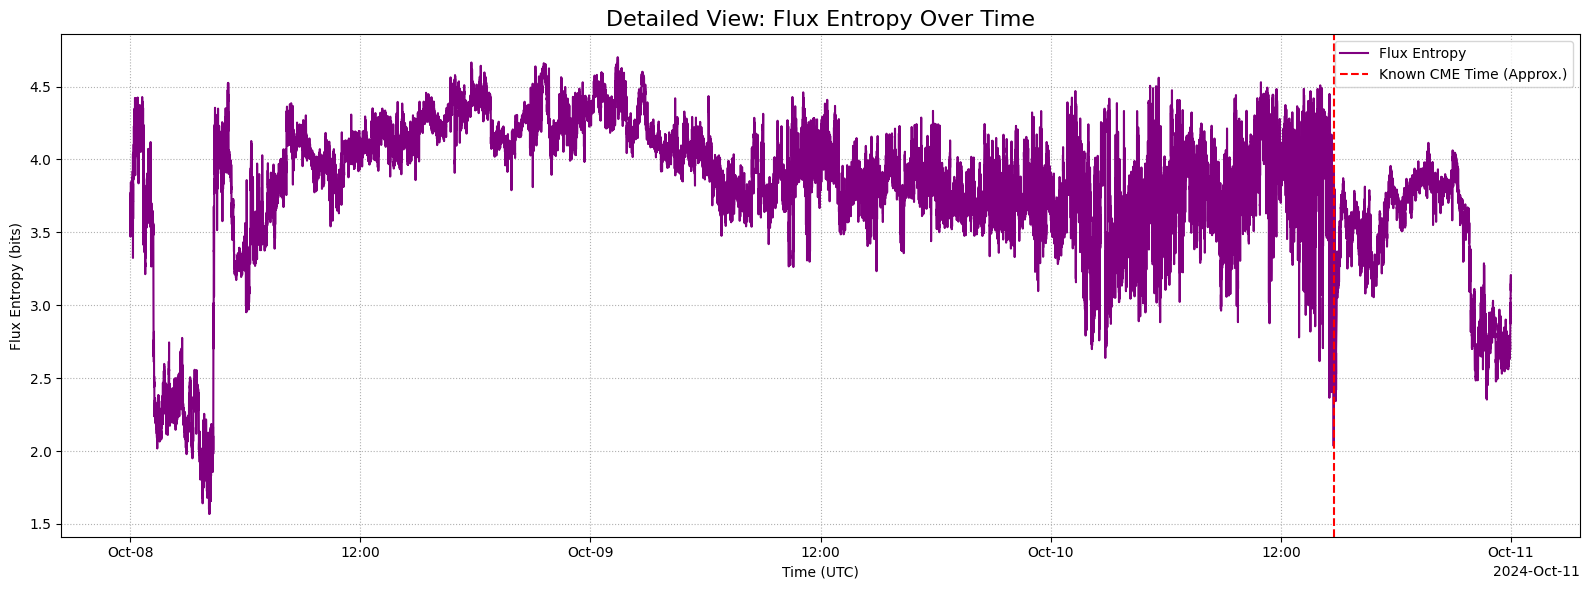

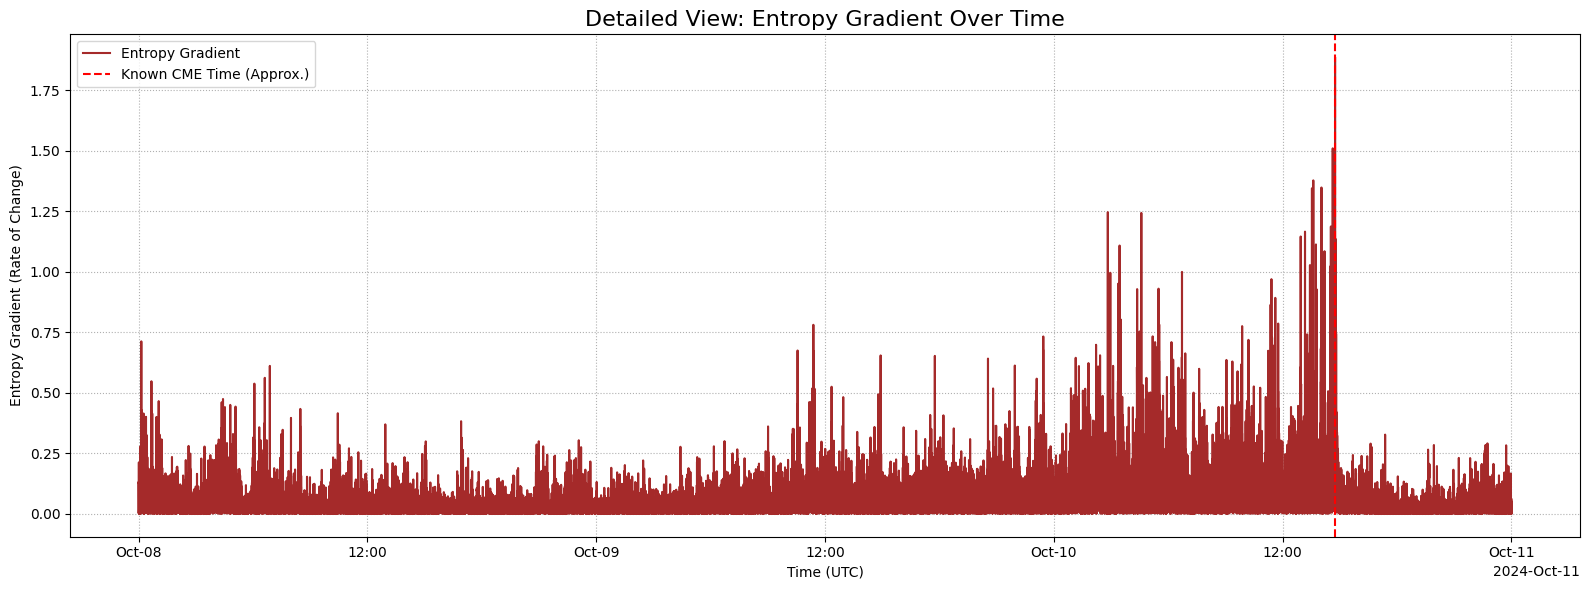

In [ ]:
# ==============================================================================
# === STEP 5: Detailed Plots for Entropy Features ===
# ==============================================================================

# This cell assumes the main pipeline has already run and the 'test_features'
# and 'known_event_time' variables exist.

print("\n Generating detailed plots for entropy features...")

# --- Plot 1: Flux Entropy Over Time ---
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(test_features.index, test_features['flux_entropy'], color='purple', label='Flux Entropy')

# Add the event marker
ax.axvline(known_event_time, color='red', linestyle='--', label='Known CME Time (Approx.)')

# Formatting
ax.set_title('Detailed View: Flux Entropy Over Time', fontsize=16)
ax.set_ylabel('Flux Entropy (bits)')
ax.set_xlabel('Time (UTC)')
ax.grid(True, linestyle=':')
ax.legend()
formatter = ConciseDateFormatter(ax.xaxis.get_major_locator())
ax.xaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()


# --- Plot 2: Entropy Gradient Over Time ---
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(test_features.index, test_features['entropy_gradient'], color='brown', label='Entropy Gradient')

# Add the event marker
ax.axvline(known_event_time, color='red', linestyle='--', label='Known CME Time (Approx.)')

# Formatting
ax.set_title('Detailed View: Entropy Gradient Over Time', fontsize=16)
ax.set_ylabel('Entropy Gradient (Rate of Change)')
ax.set_xlabel('Time (UTC)')
ax.grid(True, linestyle=':')
ax.legend()
formatter = ConciseDateFormatter(ax.xaxis.get_major_locator())
ax.xaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()